In [1]:
import shap
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
from tensorflow.keras import layers
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, optimizers, losses, metrics, Model

2023-03-09 15:21:59.024566: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-09 15:21:59.247600: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-09 15:21:59.304737: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-09 15:22:01.490024: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
#load the model
model=tf.keras.models.load_model('TrainedWeights/explained_model')

2023-03-08 13:53:54.058339: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-03-08 13:53:54.058450: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (login510-22): /proc/driver/nvidia/version does not exist
2023-03-08 13:53:54.060007: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 GLG (InputLayer)               [(None, 1)]          0           []                               
                                                                                                  
 Est_m (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 Nrt_m (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 HC_m (InputLayer)              [(None, 1)]          0           []                               
                                                                                            

In [21]:
input_layers=[]
for layer in ['Est_m','Nrt_m','HC_m','VC_m','Slp_m','Prc_m','NDVI_m','PGV_Usgs','Sand_m','Silt_m','Clay_m','Bdod_m','GLG']:

    input_layers.append(model.get_layer(layer).input)
output_layers=[]
for layer in ['normalization','normalization_1','normalization_2','normalization_3','normalization_4','normalization_5','normalization_6','normalization_7','normalization_8','normalization_9','normalization_10','normalization_11','category_encoding']:
    output_layers.append(model.get_layer(layer).output)

In [22]:
prep_model=Model(inputs=input_layers, outputs=output_layers)

In [45]:
input_layersex=model.get_layer('concatenate_1').input
output_layersex=model.output
exaimodel=Model(inputs=input_layersex, outputs=output_layersex)

In [46]:
exaimodel.save('TrainedWeights/explained_model.h5')

In [2]:
prepdata = np.load('TrainedWeights/prepdata.npz')
model=tf.keras.models.load_model('TrainedWeights/explained_model.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Colocations handled automatically by placer.


2023-03-09 15:22:20.245677: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-03-09 15:22:20.245788: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (login510-22): /proc/driver/nvidia/version does not exist
2023-03-09 15:22:20.251920: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-09 15:22:20.302179: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


In [3]:
data = [prepdata[key] for key in prepdata]
background= [arr[:100] for arr in data]
model.predict(data)

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


array([[7.4016440e-01],
       [4.3297865e-04],
       [5.1343109e-04],
       ...,
       [8.0979162e-01],
       [6.3773042e-01],
       [1.3190591e-01]], dtype=float32)

In [4]:
explainer = shap.DeepExplainer(model=model, data=background)



keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [ ]:
# shap.explainers.deep_tf.op_handlers["AddV2"] = shap.explainers.deep.deep_tf.passthrough
shap_values = explainer.shap_values(data)

In [ ]:
#cleanup shap values
numeric_covars=np.hstack(shap_values[0][:12])
cat_covars=shap_values[0][12].sum(axis=1)
total_effect=np.hstack([numeric_covars,np.expand_dims(cat_covars,axis=-1)])
shap_values=total_effect

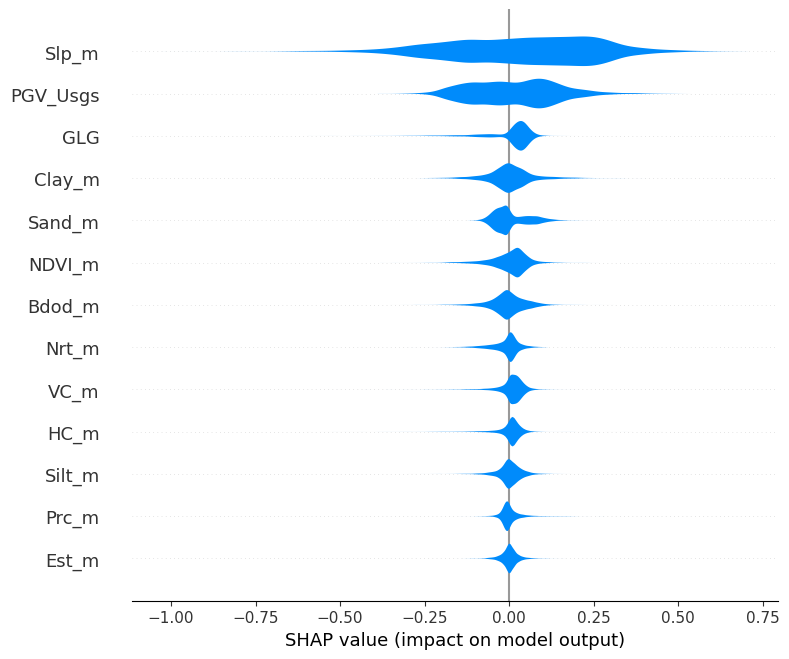

In [54]:
constcols=['Est_m','Nrt_m','HC_m','VC_m','Slp_m','Prc_m','NDVI_m','PGV_Usgs','Sand_m','Silt_m','Clay_m','Bdod_m','GLG']
shap.summary_plot(shap_values, plot_type = 'violin', feature_names = constcols,show=False)
plt.savefig('Exaiplots/overallimpactDistributionrev1.pdf')

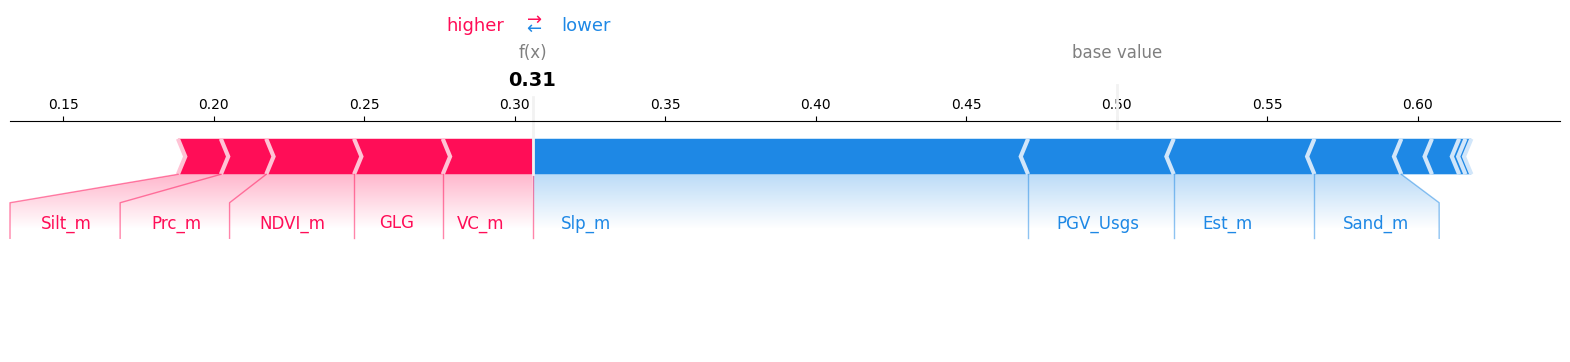

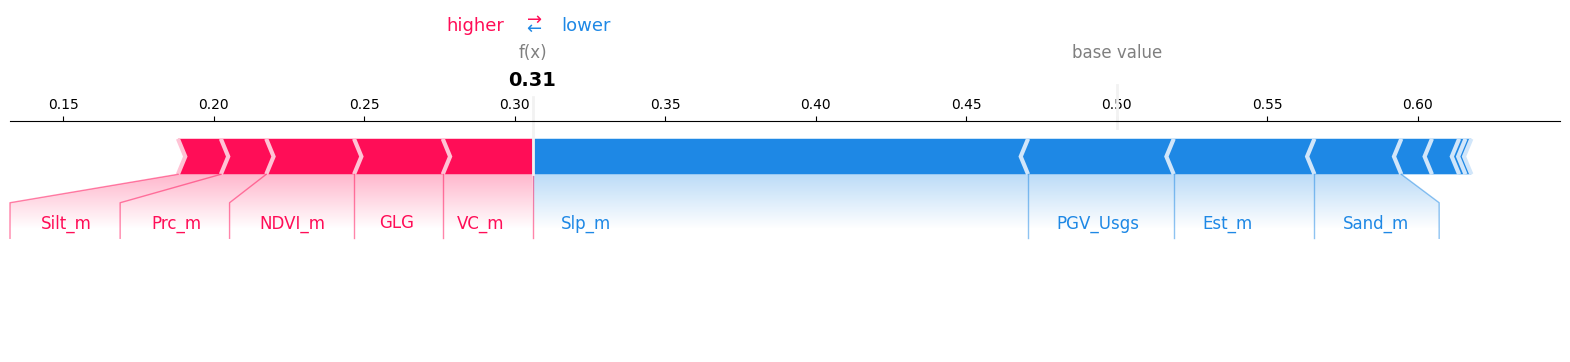

In [56]:
shap.initjs()

shap.force_plot(0.5, shap_values[8], features = constcols,matplotlib=True,feature_names = constcols,show=False)
plt.savefig('Exaiplots/singleNegativeExamplerev1.pdf')
plt.show()

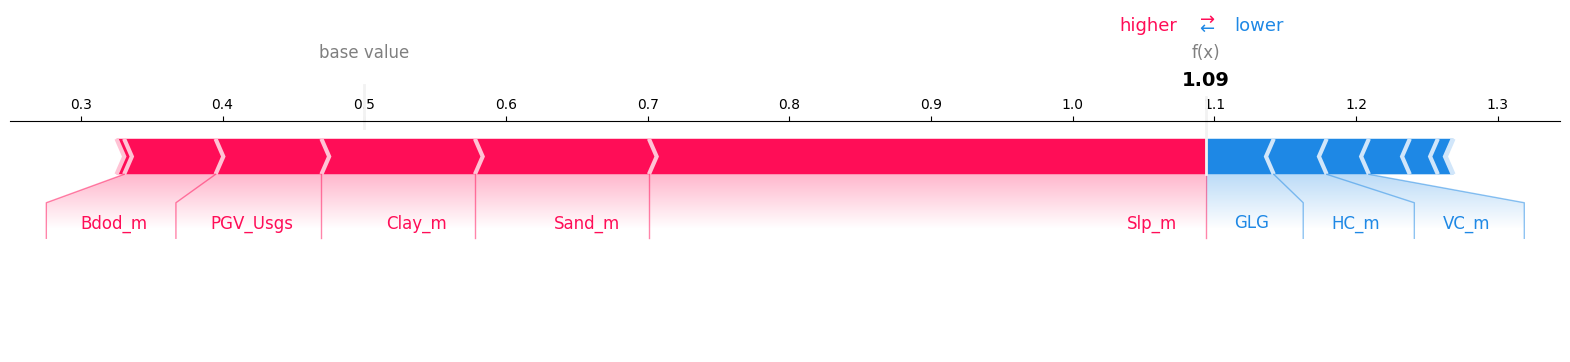

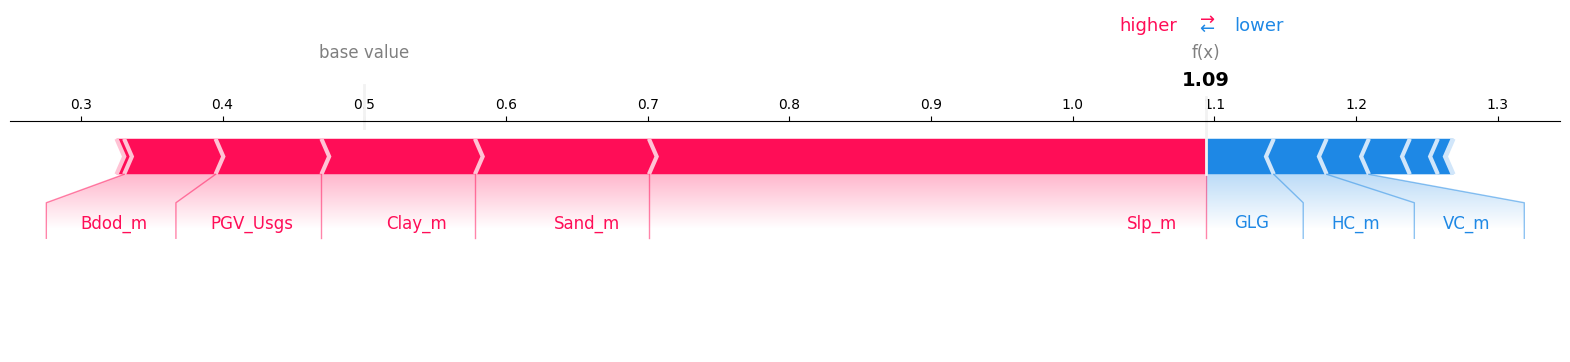

In [58]:
shap.initjs()
shap.force_plot(0.5, shap_values[10], features = constcols,matplotlib=True,feature_names = constcols,show=False)
plt.savefig('Exaiplots/SinglePositiveExamplerev1.pdf')
plt.show()

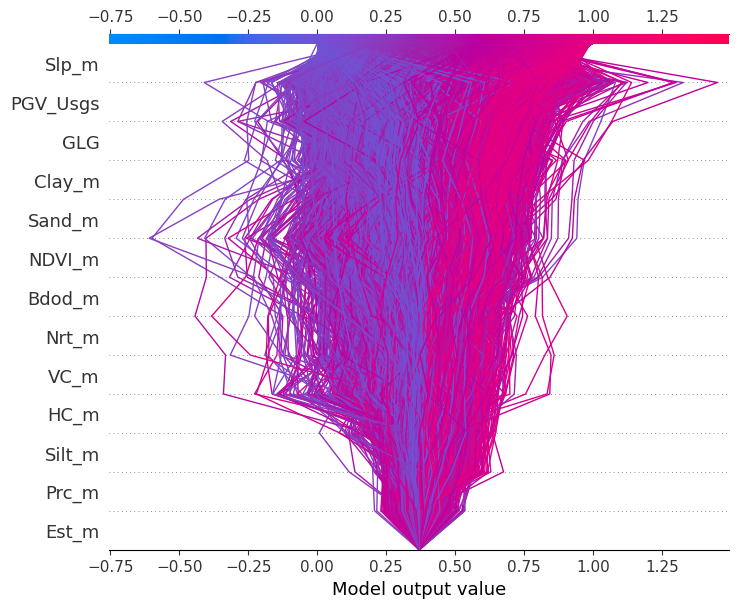

In [60]:
shap.decision_plot(explainer.expected_value[0], shap_values, features = data, feature_names = constcols,show=False,ignore_warnings=True)
plt.savefig('Exaiplots/DecisionPlot_allrev1.pdf')
plt.show()

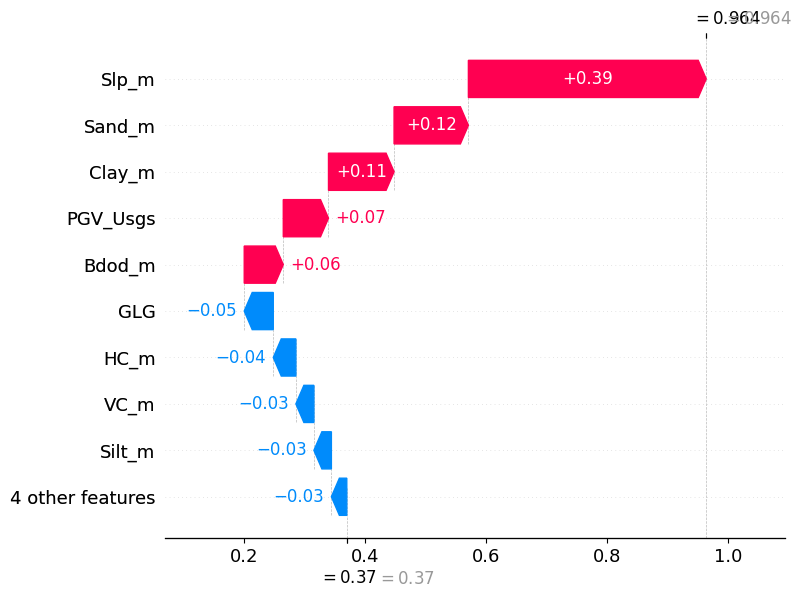

<Figure size 640x480 with 0 Axes>

In [65]:
import matplotlib.pyplot as plt
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[10], feature_names = constcols)
plt.savefig('Exaiplots/additiveNature_Positiverev1.pdf')
plt.show()

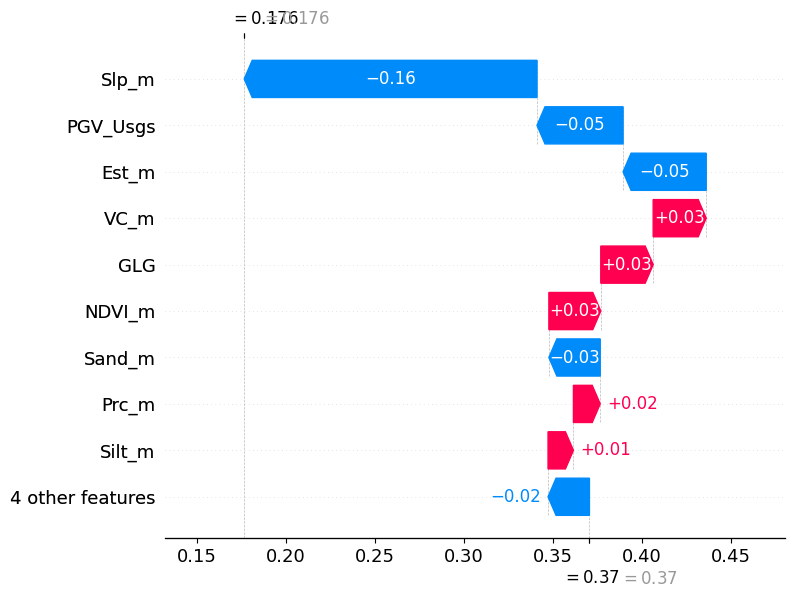

<Figure size 640x480 with 0 Axes>

In [66]:
import matplotlib.pyplot as plt
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[8], feature_names = constcols)
plt.savefig('Exaiplots/additiveNature_Negativerev1.pdf')
plt.show()

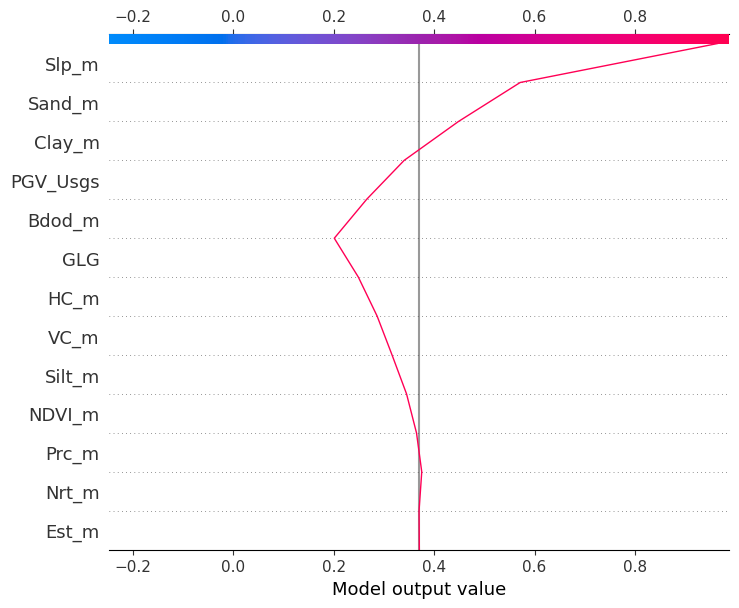

In [80]:
import matplotlib.pyplot as plt
shap.decision_plot(explainer.expected_value[0], shap_values[10], feature_names = constcols,show=False)
plt.savefig('Exaiplots/additiveNature_positivewaterrev1.pdf')
plt.show()

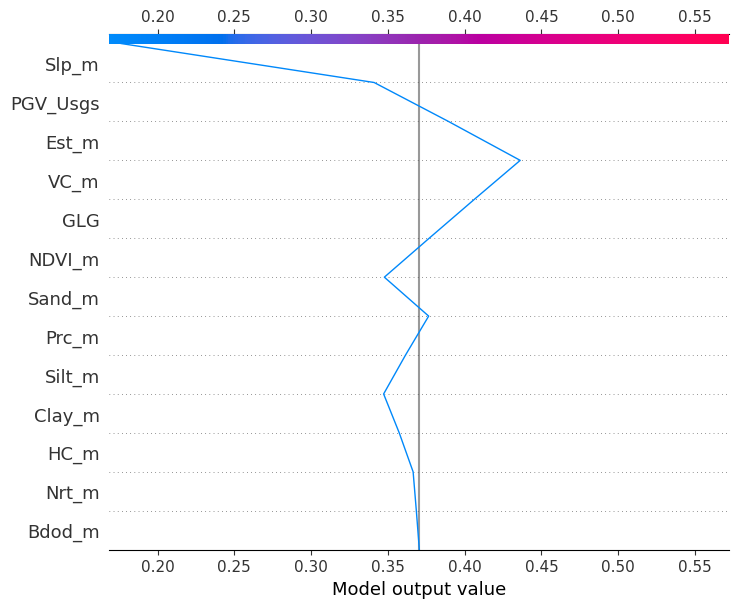

In [81]:
import matplotlib.pyplot as plt
shap.decision_plot(explainer.expected_value[0], shap_values[8], feature_names = constcols,show=False)
plt.savefig('Exaiplots/additiveNature_negativewaterrev1.pdf')
plt.show()

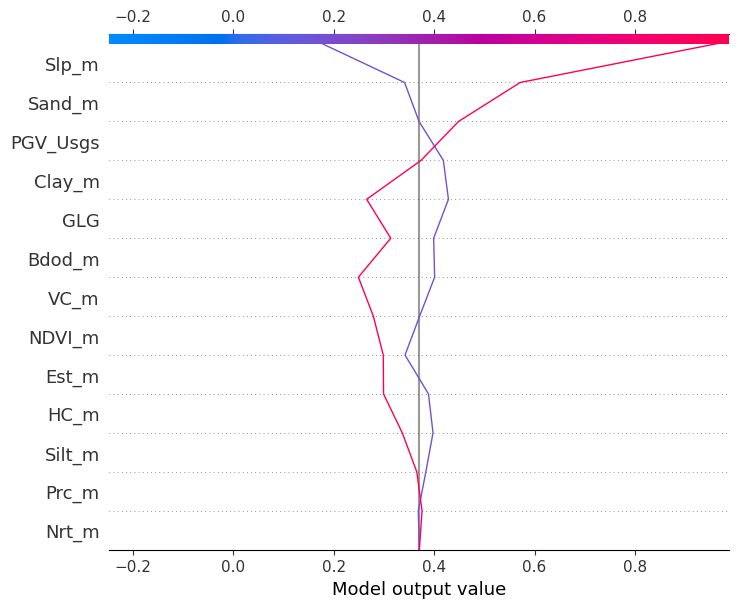

In [87]:
import matplotlib.pyplot as plt
shap.decision_plot(explainer.expected_value[0], shap_values[[8,10]], feature_names = constcols,show=False)
#shap.decision_plot(explainer.expected_value[0], shap_values[0][8], feature_names = constcols,show=False,)
plt.savefig('Exaiplots/waterfall_chkrev1.pdf',dpi=500)
plt.show()

In [ ]:
for i in range(len(shap_values[0])):
    shap.decision_plot(explainer.expected_value[0], shap_values[i], feature_names = constcols,show=False)
    plt.savefig(f'/home/dahala/Documents/ashokdahal.github.io/plotapp/{str(i)}.png',dpi=300)
    plt.tight_layout()
    plt.clf()

In [89]:
shap_values.shape

(16533, 13)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


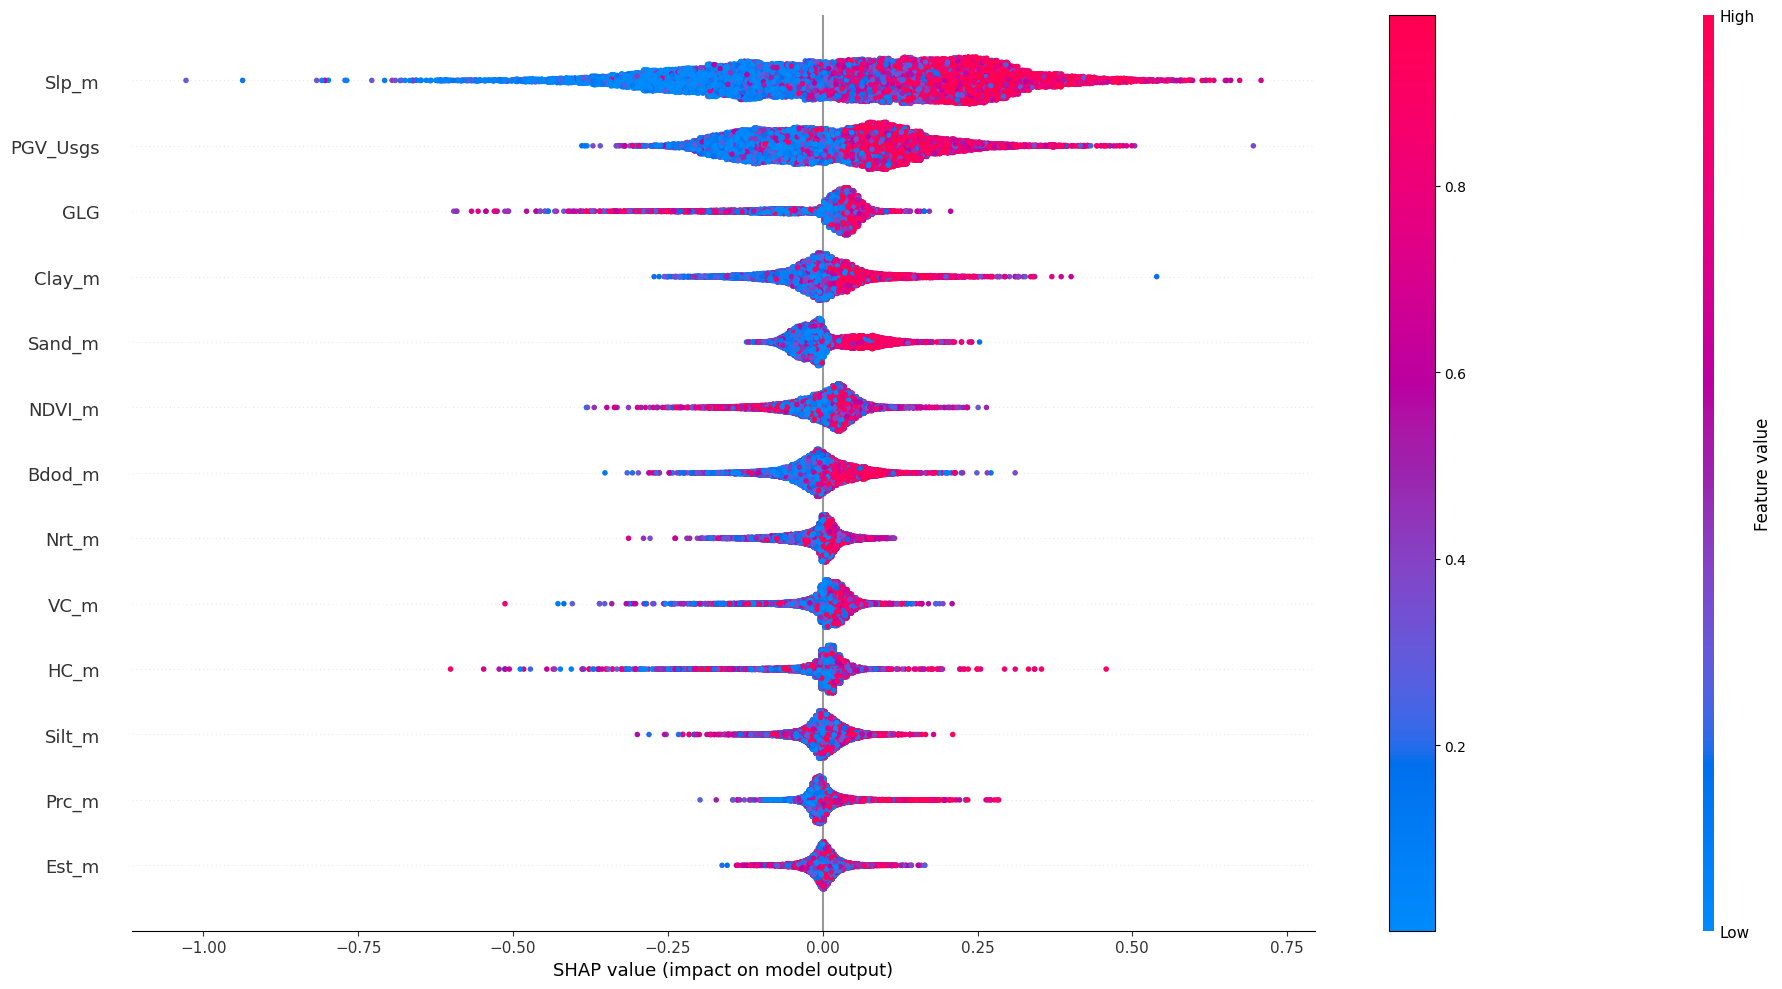

In [90]:
plt.Figure(dpi=1000)
predictions=model.predict(data)
preds_data=np.repeat(predictions,13).reshape(shap_values.shape[0],shap_values.shape[1])

shap.summary_plot(shap_values, preds_data,feature_names = constcols,show=False,plot_size=(20,10))
plt.colorbar()
plt.tight_layout()
plt.savefig('Exaiplots/Norm_value_Impact_on_SHAPrev1.pdf')
plt.show()

In [ ]:
shap.group_difference_plot(shap_values,group_mask=Ydata.astype(bool),feature_names=constcols,show=False)
plt.savefig('Exaiplots/Mean_SHAP_difference_between_landslide_noLandsliderev1.pdf')

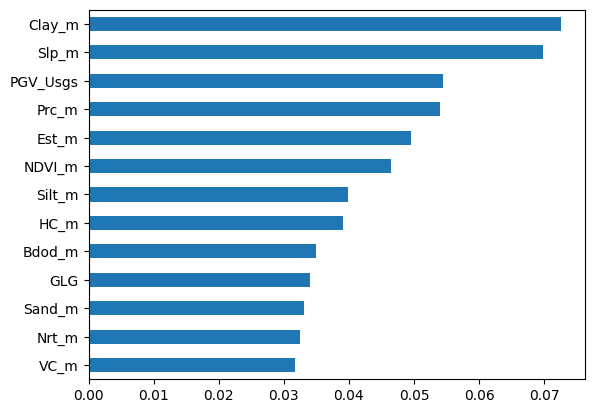

In [115]:
import pandas as pd
m_shap={}
for col in constcols:
    index=constcols.index(col)
    m_shap[col]=np.abs(shap_values[index]).flatten()
df_mshap=pd.DataFrame(m_shap)
df_mshap.mean().sort_values(ascending=True).plot(kind='barh')
plt.savefig('Exaiplots/Mean_SHAP_difference_between_landslide_noLandsliderev1.pdf')
plt.show()

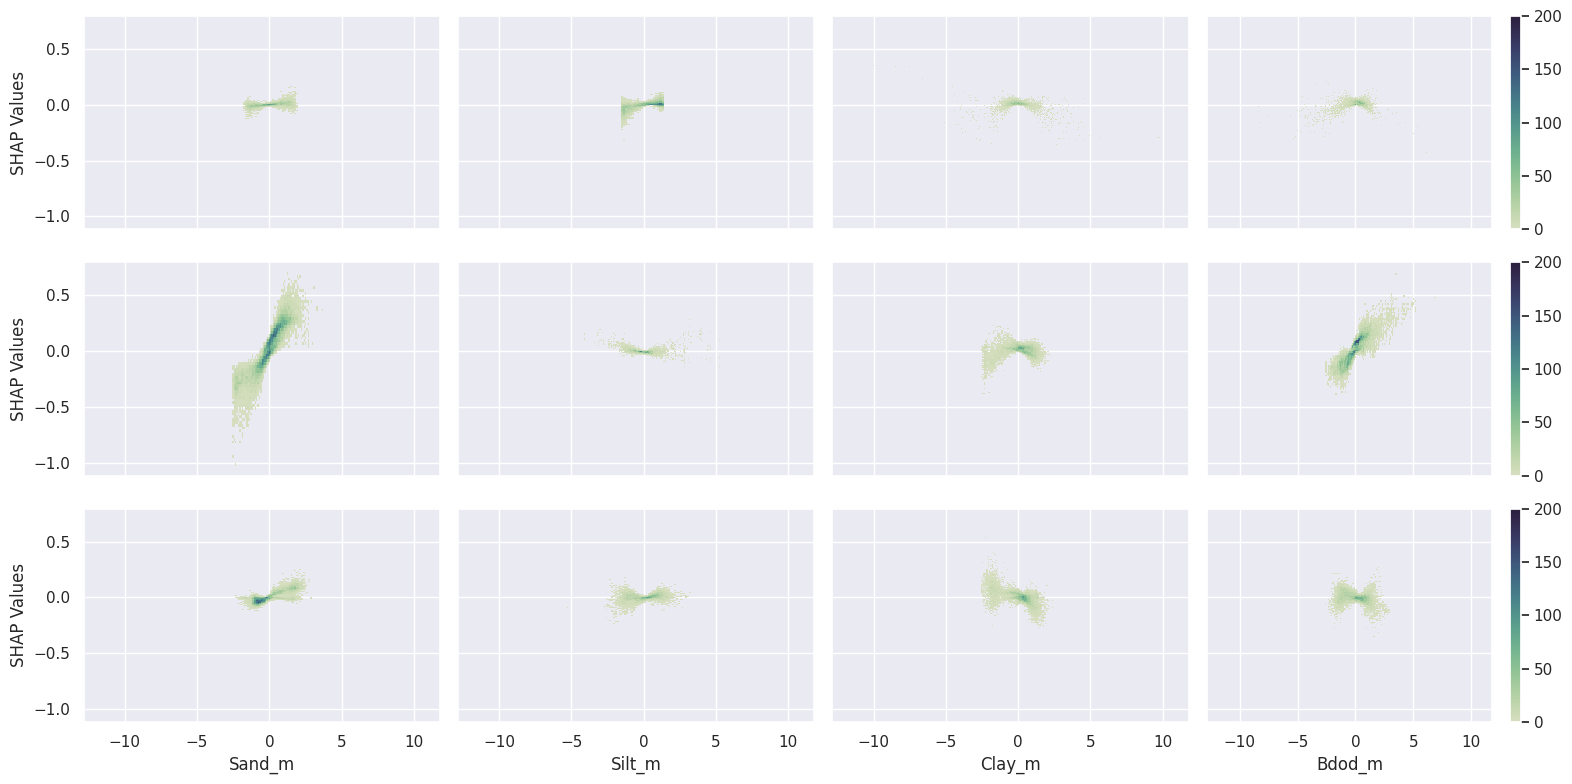

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
fig,axs=plt.subplots(3, 4, figsize=(16,8),sharey=True,sharex=True)
df_sub=df[constcols]
i=0
j=0
for col in range(12):
    if not (j==3):
        ax=sns.histplot(y=shap_values[:,col].flatten(), x=data[col].flatten(),ax=axs[i,j],cbar=False,cmap=sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True),vmin=0, vmax=200)
    else:
        ax=sns.histplot(y=shap_values[:,col].flatten(), x=data[col].flatten(),ax=axs[i,j],cbar=True,cmap=sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True),vmin=0, vmax=200)

    # shap.dependence_plot((col), shap_values[0], norm_xdata,interaction_index=None,show=False,cmap='viridis',ax=axs[i,j],feature_names=constcols)
    j+=1
    if j ==4:
        i=i+1
        j=0
    ax.set_xlabel(f'{constcols[col]}')
    ax.set_ylabel('SHAP Values')
    
#ax.colorbar()
plt.tight_layout()
plt.savefig('Exaiplots/Variable_Influence_Distributionrev1.pdf')
plt.show()

In [ ]:
preds=model.predict(norm_xdata)

In [ ]:
for i in range(len(df)):
    df.loc[i, 'url'] = f"https://raw.githubusercontent.com/ashokdahal/ashokdahal.github.io/master/plotapp/{i}.png"
    df.loc[i,'susceptibility']=preds[i][0]

In [ ]:
df_web=df[['url','susceptibility','geometry']]

In [ ]:
df_web.to_file('Exaiplots/WebappData.gpkg',driver='GPKG')